# Parameter Estimation Using Bilby

## Generating the Waveform Using Bilby

In [1]:
from __future__ import division, print_function

import numpy as np
import bilby
import matplotlib.pyplot as plt

#duration- Length of Data in Seconds
#Sampling Frequency- Number of data points per seconds generated by the detector. Usually the detector outputs
#16000 points per second
# 1/sampling_frequency gives the time between successive outputs.

duration = 4
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'Custom Parameters'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility
np.random.seed(200)


In [2]:
parameters = dict(
    mass_1=40, mass_ratio=0.5, a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.1, luminosity_distance=1000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

#We want to sample in m1 and q just for fun!
# Our prior dictionary looks something like this.

priors = bilby.core.prior.PriorDict()
priors['mass_1'] = bilby.core.prior.Uniform(minimum=10, maximum = 60,name = 'mass_1', latex_label='$m_1$')
priors['mass_ratio'] =  bilby.core.prior.Uniform(minimum=0.4, maximum = 0.6,name = 'mass_ratio', latex_label='q')
priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=parameters['geocent_time'] - 1,
    maximum=parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl','luminosity_distance','theta_jn', 'psi', 'ra',
            'dec', 'geocent_time','phase']:
    priors[key] = parameters[key]

def conversion_function(param):
    converted_parameters = param.copy()
    added_keys = list()
    m1 = param['mass_1']
    q = param['mass_ratio']
    m2 = m1/q
    converted_parameters['mass_2'] = m2
    added_keys+= ['mass_2']
    return converted_parameters,added_keys
    
# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50.)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=conversion_function,
    waveform_arguments=waveform_arguments)


21:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: __main__.conversion_function


In [3]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity

detectors = bilby.gw.detector.InterferometerList(['H1', 'L1'])


strain=detectors.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=parameters['geocent_time'] - 3)

signal=detectors.inject_signal(waveform_generator=waveform_generator,
                   parameters=parameters)


/home/abhi/anaconda3/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
21:03 bilby INFO    : Injected signal in H1:
21:03 bilby INFO    :   optimal SNR = 33.61
21:03 bilby INFO    :   matched filter SNR = 33.21+0.92j
21:03 bilby INFO    :   mass_1 = 40
21:03 bilby INFO    :   mass_ratio = 0.5
21:03 bilby INFO    :   a_1 = 0.4
21:03 bilby INFO    :   a_2 = 0.3
21:03 bilby INFO    :   tilt_1 = 0.5
21:03 bilby INFO    :   tilt_2 = 1.0
21:03 bilby INFO    :   phi_12 = 1.7
21:03 bilby INFO    :   phi_jl = 0.1
21:03 bilby INFO    :   luminosity_distance = 1000.0
21:03 bilby INFO    :   theta_jn = 0.4
21:03 bilby INFO    :   psi = 2.659
21:03 bilby INFO    :   phase = 1.3
21:03 bilby INFO    :   geocent_time = 1126259642.413
21:03 bilby INFO    :   ra = 1.375
21:03 bilby INFO    :   dec = -1.2108
21:03 bilby INFO    : Injected s

In [4]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=detectors, waveform_generator=waveform_generator,priors=priors)


In [ ]:
#I ran this already. And the files were stored.
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=200,
    injection_parameters=parameters, outdir=outdir,
    label=label)

In [5]:
result = bilby.result.read_in_result(outdir=outdir, label=label)

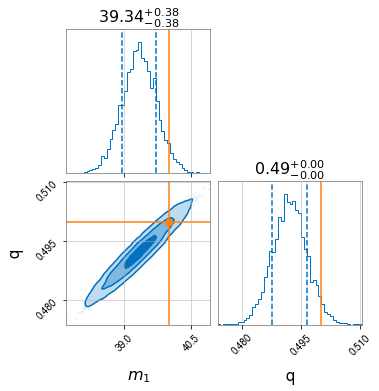

In [8]:
result.plot_corner()